In [1]:
import pandas as pd
import numpy as np
import re
import os
import wave
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
from pathlib import Path


C:\Users\Magnus\AppData\Local\Temp\ipykernel_11860\3839086761.py:6: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [2]:
meta_df = pd.read_csv(os.path.join(Path.cwd().parent, "Data", "meta.csv"))

<AxesSubplot: >

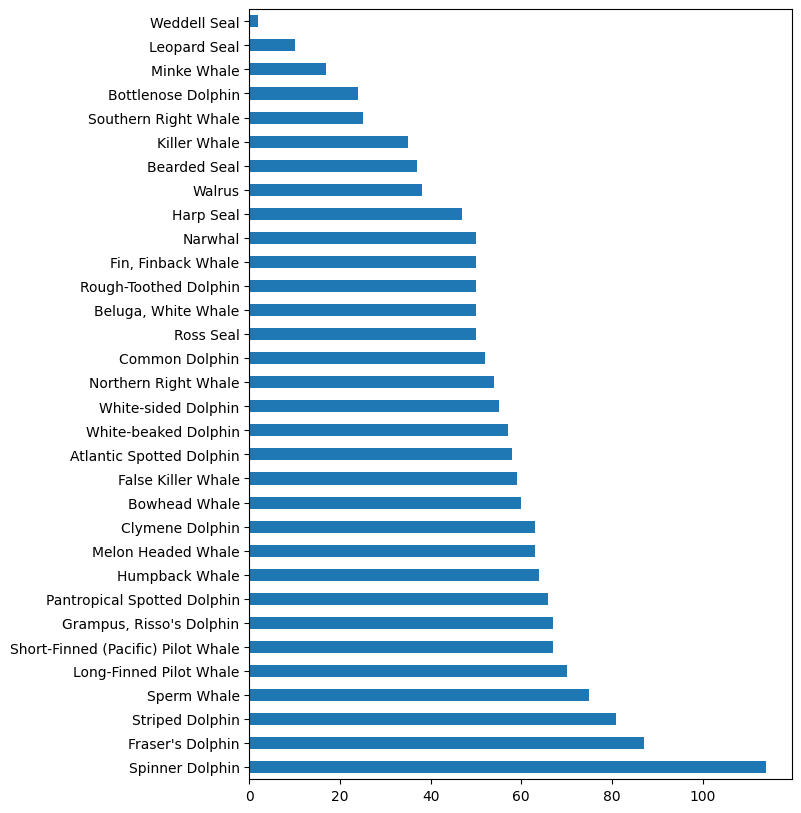

In [3]:
meta_df.species.value_counts().plot(kind="barh", figsize=(7,10))

In [4]:
meta_df = meta_df[["species", "filename", "RN:", "SR:", "CS:", "GS:", "GA:", 
                   "OD:", "OS:", "NA:", "SH:", "HY:", "RC:", "RG:", "SL:", "ST:"]]

Making a seperate columns for the species code and scientific species name:

In [5]:
# If the recording contains several sound sources each source is seperated by "|"
l = meta_df["GS:"].str.split("|")
l.apply(len).unique()

array([1, 2, 3], dtype=int64)

This means that there exists recordings with up to three sounds (both animals and noise). So first I make a seperate column for each sound:

In [6]:
def f1(x):
    if len(x)>1:
        return x[1]

In [7]:
def f2(x):
    if len(x)>2:
        return x[2]

In [8]:
meta_df["Sound 1"] = l.apply(lambda x: x[0]).str.strip()
meta_df["Sound 2"] = l.apply(f1).str.strip()
meta_df["Sound 3"] = l.apply(f2).str.strip()

In [9]:
def f10(x):
    if type(x) == float:
        return x

And then split up the code and the name of the sound source

In [10]:
def f3(x):
    if x == None:
        return None
    elif len(x) == 1:
        x = x[0].split(" ")
        if len(x)==2:
            name = x[0].title()
            code = x[1].upper()
        elif len(x) == 3:
            if x[1].upper() == "X" or len(re.findall("[A-Z0-9]", x[1])) > 2:   
                name = x[0].title().strip()
                code = x[1].upper().strip()
            else:
                name = x[0].title().strip() + " " + x[1].strip()
                code = x[2].upper().strip()
        return [name.strip(), code.strip()]
    else:
        return x

In [11]:
def f4(x):
    if x == None or x == np.nan:
        return None
    else:
        return x[0].strip()

In [12]:
def f5(x):
    if x == None or x == np.nan:
        return None
    else:
        return x[1].strip()

In [13]:
meta_df["S1SN"] = meta_df["Sound 1"].str.strip().\
    str.split("  ").apply(f3).apply(f4)
meta_df["S1SC"] = meta_df["Sound 1"].str.strip().\
    str.split("  ").apply(f3).apply(f5)
meta_df["S2SN"] = meta_df["Sound 2"].str.strip().\
    str.split("  ").apply(f3).apply(f4)
meta_df["S2SC"] = meta_df["Sound 2"].str.strip().\
    str.split("  ").apply(f3).apply(f5)
meta_df["S3SN"] = meta_df["Sound 3"].str.strip().\
    str.split("  ").apply(f3).apply(f4)
meta_df["S3SC"] = meta_df["Sound 3"].str.strip().\
    str.split("  ").apply(f3).apply(f5)

In [14]:
meta_df = meta_df.drop(['Sound 1', 'Sound 2' , "Sound 3"], axis=1)

Making extra columns with all the nosie in the recording in a list aswell as the number of different noises in the recording

In [15]:
nl = []
num_noise = []

for i, (index, row) in enumerate(meta_df.iterrows()):
    l = []
    if row["S1SC"] == "X":
        l.append(row["S1SN"])
    if row["S2SC"] == "X":
        l.append(row["S2SN"])
    if row["S3SC"] == "X":
        l.append(row["S3SN"])
    nl.append(l)
    num_noise.append(len(l))
    
meta_df["Noise"] = nl
meta_df["Noise count"] = num_noise

Making extra columns with all the species in the recording in a list aswell as the number of different species in the recording

In [16]:
sl = []
num_species = []

for i, (index, row) in enumerate(meta_df.iterrows()):
    l = []
    if row["S1SC"] != "X" and row["S1SC"] != None:
        l.append(row["S1SN"])
    if row["S2SC"] != "X" and row["S2SC"] != None:
        l.append(row["S2SN"])
    if row["S3SC"] != "X" and row["S3SC"] != None:
        l.append(row["S3SN"])
    sl.append(l)
    num_species.append(len(l))
    
meta_df["All species"] = sl
meta_df["Species count"] = num_species

Making a table that describes the column codes:

In [17]:
codes = pd.DataFrame(columns=["Code", "Meaning"])
data = {
    'Code': ["RN:", "SR:", "CS:", "GS:", "GA:", "OD:", "OS:", 
             "NA:", "SH:", "HY:", "RC:", "RG:", "SL:", "ST:", "S1SN", 
             "S1SC", "S2SN", "S2SC", "S3SN", "S3SC"], 
    'Meaning': ["ID number", "Sample rate", "Length (seconds)", 
                "Scientific name and code", "Geographic location code",
                "Date", "Other species present",
                "Number of animals vocalizing, species codes",
                "Setting", "Hydrophone depth", "Recording conditions",
                "Recording Equipment",
                "Signal Level", "Signal Type", "Name of sound 1",
                "Code of sound 1", "Name of sound 2",
                "Code of sound 2", "Name of sound 3", "Code of sound 3"]}

codes = pd.DataFrame(data=data)
codes

,Code,Meaning
0,RN:,ID number
1,SR:,Sample rate
2,CS:,Length (seconds)
3,GS:,Scientific name and code
4,GA:,Geographic location code
5,OD:,Date
6,OS:,Other species present
7,NA:,"Number of animals vocalizing, species codes"
8,SH:,Setting
9,HY:,Hydrophone depth


Finding all the unique noise values:

In [18]:
s = set()

meta_df[meta_df["Noise count"] > 0][["Noise", "S1SN", "S2SN", "S3SN"]]

for ele in list(meta_df["Noise"]):
    for noise in ele:
        s.add(noise)
print(s)

{'Crash', 'Ambient', 'Water noise', 'Ice crunch', 'Ambient click', 'Machinery noise', 'Pingers', 'Ship engine noise', 'Electrical noise', 'Ship noise', 'Pinger', 'Ice', 'Water droplets', 'Ship electrical noise', 'Water splash', 'Ambient noise', 'Cable noise', 'Water', 'Ship cracks', 'Transient', 'Transient ship noise', 'Cracks', 'Crack'}


Counting how many recordings contain noise:

In [19]:
len(meta_df[meta_df["Noise count"] > 0])

337

Counting how many recordings contain 2 species:

In [20]:
len(meta_df[meta_df["Species count"] > 1])

76

As the recordings that contain 2 species are duplicated (since they exist on both the species pages), to count all the unique recordings we need to remove half of them:

In [21]:
len(meta_df) - len(meta_df[meta_df["Species count"] > 1])/2

1659.0

Counting the different locations per species and plotting them

In [22]:
meta_df["GA:"] = meta_df["GA:"].str[0:3]

<AxesSubplot: ylabel='species'>

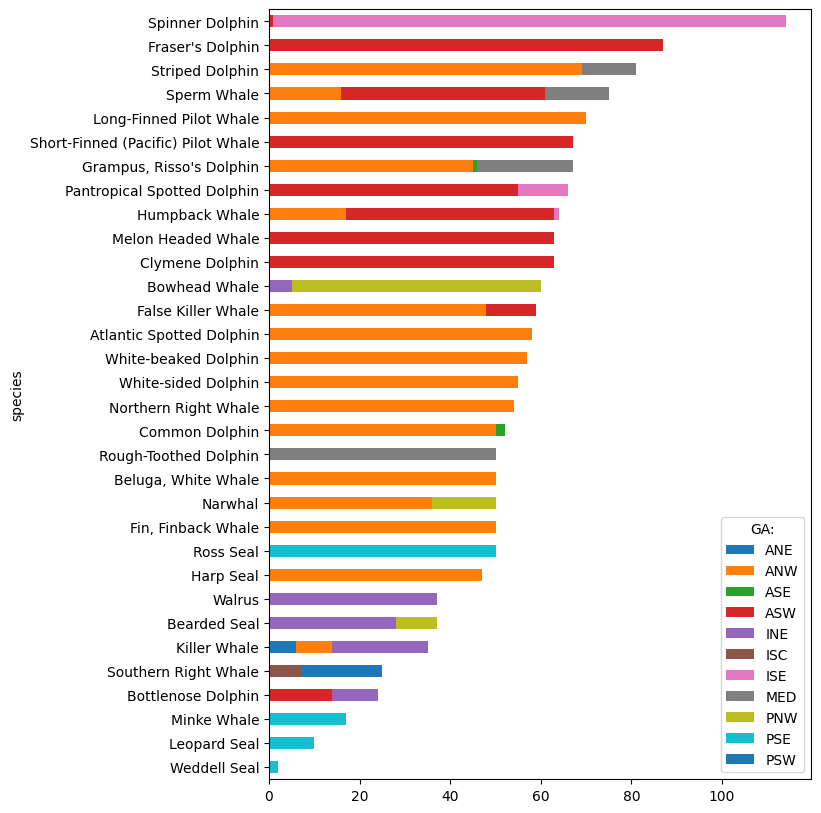

In [23]:
geo = pd.DataFrame(meta_df.groupby("species")["GA:"]\
                   .value_counts()).unstack()
geo["Count"] = meta_df.groupby("species")["filename"].count()
geo.sort_values(by="Count")["GA:"].plot.barh(stacked=True, figsize=(7,10))

How many different geographic locations were used:

In [24]:
len(meta_df["GA:"].dropna().unique())

11

In [25]:
meta_df["GA:"].unique()

array(['ANW', 'INE', 'PNW', 'ASW', 'ASE', 'MED', 'ISE', 'ANE', 'PSE',
       'PSW', 'ISC', nan], dtype=object)

Plot of the number of unique recording locations per species and its description:

<AxesSubplot: ylabel='species'>

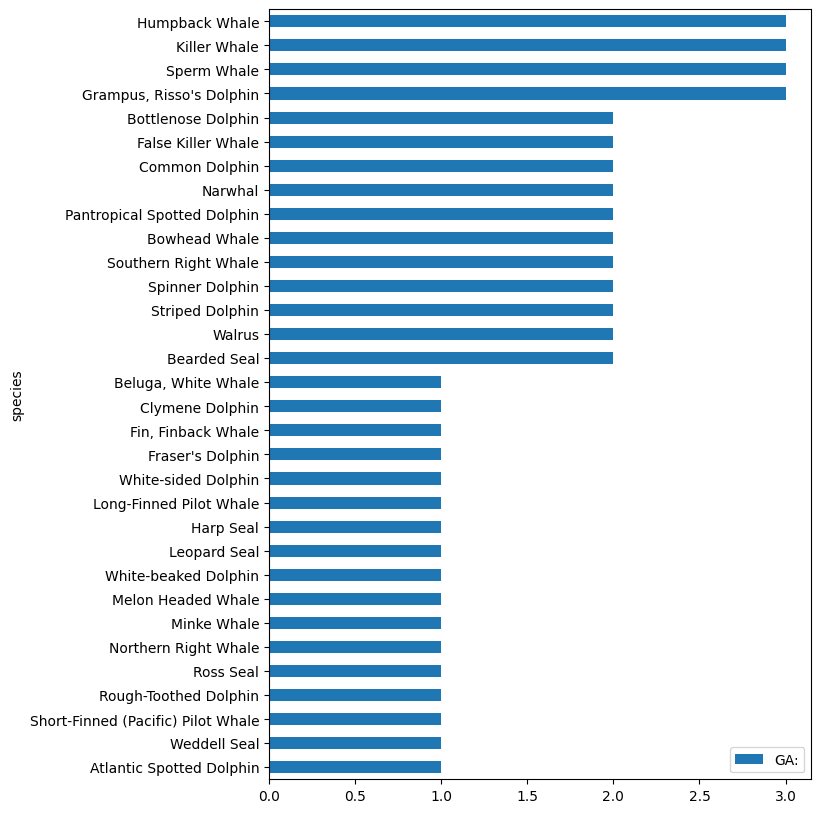

In [26]:
pd.DataFrame(meta_df.groupby("species")["GA:"].unique().apply(len)) \
.sort_values(by="GA:").plot(kind="barh", figsize=(7,10))

In [27]:
pd.DataFrame(meta_df.groupby("species")["GA:"].unique().apply(len)).describe()

,GA:
count,32.000000
mean,1.593750
std,0.712079
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,3.000000


Finding the number of unique recording gear per species and description:

<AxesSubplot: ylabel='species'>

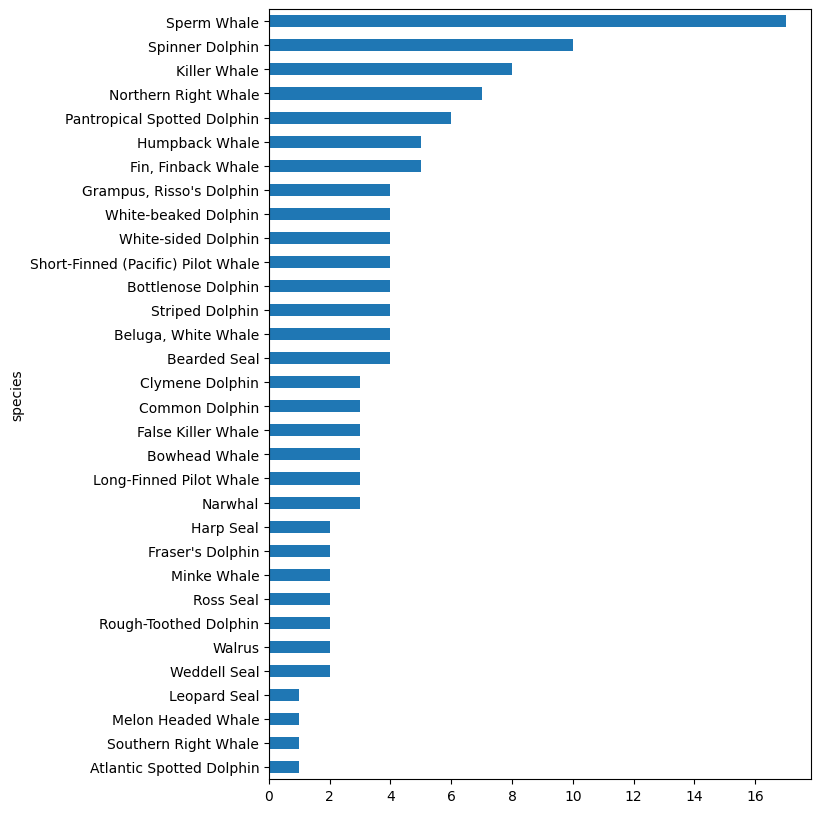

In [28]:
meta_df.groupby("species")["RG:"].unique().apply(len).\
    sort_values().plot(kind="barh", figsize=(7,10))

In [29]:
meta_df.groupby("species")["RG:"].unique().apply(len).describe()

count    32.000000
mean     3.937500 
std      3.141168 
min      1.000000 
25%      2.000000 
50%      3.000000 
75%      4.000000 
max      17.000000
Name: RG:, dtype: float64

Fixing some bad formatting in SR:

In [30]:
meta_df["SR:"][meta_df["SR:"] == "10,000"] = "10000"

C:\Users\Magnus\AppData\Local\Temp\ipykernel_13252\3805512850.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta_df["SR:"][meta_df["SR:"] == "10,000"] = "10000"


In [31]:
meta_df["SR:"] = meta_df["SR:"].str.strip()

Fixing some nan values in SR

In [32]:
root = r"C:\datasets\whoi\audio"
for i, x in enumerate(meta_df.iterrows()):
    if type(x[1][3]) != str:
        print(type(x[1][3]))
        path = os.path.join(root, x[1][0], x[1][1])
        with wave.open(path, "rb") as wave_file:
            frame_rate = wave_file.getframerate()
        print(meta_df["SR:"].iloc[i])
        meta_df["SR:"].iloc[i] = str(frame_rate)

<class 'float'>
nan
<class 'float'>
nan
<class 'float'>
nan


C:\Users\Magnus\AppData\Local\Temp\ipykernel_13252\332042886.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta_df["SR:"].iloc[i] = str(frame_rate)


In [33]:
meta_df["SR:"] = meta_df["SR:"].astype(int)

In [34]:
meta_df["SR:"].describe()

count    1697.000000  
mean     57766.806128 
std      36770.373001 
min      600.000000   
25%      20000.000000 
50%      80000.000000 
75%      81920.000000 
max      166600.000000
Name: SR:, dtype: float64

In [35]:
meta_df["Date"] = meta_df["OD:"].\
    apply(lambda x: re.findall("^\d{1,2}\W\w+\W\d{2,4}", x))

In [36]:
meta_df["Date"][meta_df["Date"].apply(len) == 0] = \
meta_df[meta_df["Date"].apply(len) == 0]["OD:"] \
.apply(lambda x: re.findall("^(\d+|\w{3}-?\d*)", x))

C:\Users\Magnus\AppData\Local\Temp\ipykernel_13252\310537507.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta_df["Date"][meta_df["Date"].apply(len) == 0] = \


In [37]:
meta_df["Date"] = meta_df["Date"].apply(lambda x: x[0])

In [38]:
meta_df["Date"][meta_df["Date"].apply(len) == 10] =\
meta_df["Date"][meta_df["Date"].apply(len) == 10].str.zfill(11)
meta_df["Date"][meta_df["Date"].apply(len) == 9] = \
meta_df["Date"][meta_df["Date"].apply(len) == 9]\
    .apply(lambda x: x[:-2] + "19" + x[-2:])
meta_df["Date"][meta_df["Date"].apply(len) == 8] =\
meta_df["Date"][meta_df["Date"].apply(len) == 8]\
    .apply(lambda x: "01-" + x)
meta_df["Date"][meta_df["Date"].apply(len) == 4] =\
meta_df["Date"][meta_df["Date"].apply(len) == 4]\
    .apply(lambda x: "01-Jan-" + x)
meta_df["Date"][meta_df["Date"].apply(len) == 12] =\
meta_df["Date"][meta_df["Date"].apply(len) == 12]\
    .apply(lambda x: x.replace("e", ""))
meta_df["Date"][meta_df["Date"].apply(len) == 3] = None

C:\Users\Magnus\AppData\Local\Temp\ipykernel_13252\2119195608.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta_df["Date"][meta_df["Date"].apply(len) == 10] =\
C:\Users\Magnus\AppData\Local\Temp\ipykernel_13252\2119195608.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta_df["Date"][meta_df["Date"].apply(len) == 9] = \
C:\Users\Magnus\AppData\Local\Temp\ipykernel_13252\2119195608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

In [39]:
def f(x):
    if x == None:
        return None
    else:
        return int(x[7:])

meta_df["Date"] = meta_df["Date"].apply(f)

In [40]:
years = pd.DataFrame(meta_df.groupby("species")["Date"]\
                     .value_counts()).unstack()

In [41]:
years = pd.DataFrame(meta_df.groupby("species")["Date"]\
                     .value_counts()).unstack()
years["Count"] = meta_df.groupby("species")["filename"].count()

Over how many years for each species?

In [42]:
years = years.Date
years = years.reset_index()

In [43]:
year_ranges = {}
for i in range(len(years)):
    species = years.iloc[i][0]
    max_year = years.iloc[i].dropna().index[1:].max()
    min_year = years.iloc[i].dropna().index[1:].min()
    year_ranges[species] = max_year - min_year   

In [44]:
pd.DataFrame([year_ranges]).T.rename(columns = {0: "Range"})\
    .describe()

,Range
count,31.000000
mean,15.645161
std,14.414225
min,0.000000
25%,0.000000
50%,13.000000
75%,28.500000
max,41.000000


<AxesSubplot: >

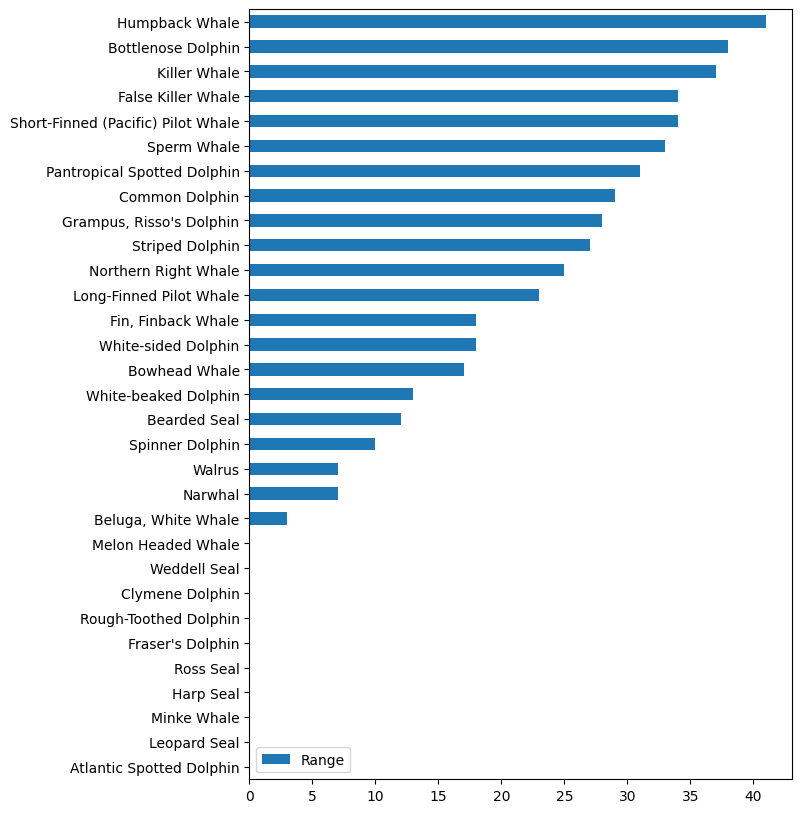

In [45]:
pd.DataFrame([year_ranges]).T.rename(columns = {0: "Range"}).\
sort_values(by="Range").plot(kind="barh", figsize=(7,10))

In [46]:
print(years.columns[1:].min(), years.columns[1:].max())

1951.0 1997.0
